In [2]:
%load_ext autoreload
%autoreload 2

import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch

# Required for jupyterlab to recognize imports
sys.path.append("/home/wangbrh/BrainProject/")
sys.path.append("/home/wangbrh/BrainProject/results")
sys.path.append("/home/wangbrh/BrainProject/utils")
sys.path.append("/home/wangbrh/BrainProject/utils/models")
sys.path.append("/home/wangbrh/BrainProject/datasets/forrest/movie_snapshots")

# Train Autoencoders

In [ ]:
import torchvision
from torch.utils.data import DataLoader
from utils import datasets, paths
from models import SimpleConvAE, SimpleConvAESmall, FeatureNet
from utils.fitutils import fit_autoencoders

# image_transforms: transformations for dataset
# images_ds: pytorch ImageFolder dataset for autoencoder training
# images_dl: pytorch Dataloader for autoencoder training
# autoencoders: dictionary of declared models to be trained (modify this)

image_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((64, 64)),
    torchvision.transforms.ToTensor(),
])
images_ds = torchvision.datasets.ImageFolder(
    root=paths.objects_dataset_path,
    transform=image_transforms
)
images_dl = DataLoader(images_ds, batch_size=16, shuffle=True, num_workers=8, pin_memory=True)

autoencoders = {
    'SimpleConvAE':  SimpleConvAE().cuda(),
    'SimpleConvAESmall': SimpleConvAESmall().cuda()
}

fit_autoencoders(images_dl, autoencoders, epochs=100, save_name='test')

# Train sparse autoencoder

In [46]:
from torch import nn
from torch.autograd import Variable

# modify this class
SPARSE_REG = 1e-3

class SparseConvAE(nn.Module):
    def __init__(self):
        super().__init__()

        # in: b, 3, 64, 64
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 16, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2, stride=2, return_indices=True),
        )

        self.unpool = nn.MaxUnpool2d(2, stride=2, padding=0)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16, 16, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 3, stride=1, padding=1),
            nn.ReLU(),
        )

    def forward(self, x):
        encoded, indices = self.encoder(x)
        out = self.unpool(encoded, indices)
        out = self.decoder(out)
        return (out, encoded)
      
def sparse_loss(autoencoder, images):
    loss = 0
    values = images

# conv layer 1
    fc_layer = list(autoencoder.encoder.children())[0]
    relu = list(autoencoder.encoder.children())[1]
    values = relu(fc_layer(values))
    loss += torch.mean(torch.abs(values))

    # conv layer 2
    fc_layer = list(autoencoder.encoder.children())[3]
    relu = list(autoencoder.encoder.children())[4]
    values = relu(fc_layer(values))
    loss += torch.mean(torch.abs(values))

    fc_layer = list(autoencoder.decoder.children())[0]
    relu = list(autoencoder.decoder.children())[1]
    values = relu(fc_layer(values))
    loss += torch.mean(torch.abs(values))


    fc_layer = list(autoencoder.decoder.children())[2]
    relu = list(autoencoder.decoder.children())[3]
    values = relu(fc_layer(values))
    loss += torch.mean(torch.abs(values))
    return loss

def model_training(autoencoder, train_loader, epochs = 50):

    loss_metric = nn.MSELoss()
    optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001, weight_decay=0.0001)
    autoencoder.train()
    
    for epoch in range(epochs): 
        for i, batch in enumerate(train_loader):
            optimizer.zero_grad()
            (inputBatch, labelBatch) = batch
            inputBatch = inputBatch.cuda()
            outputs = autoencoder(inputBatch)[0]
            mse_loss = loss_metric(outputs, inputBatch)
            l1_loss = sparse_loss(autoencoder, inputBatch)
            loss = mse_loss + SPARSE_REG * l1_loss
            loss.backward()
            optimizer.step()
            if (i + 1) % 100 == 0:
                print('Epoch [{}/{}] - Iter[{}/{}], Total loss:{:.4f}, MSE loss:{:.4f}, Sparse loss:{:.4f}'.format(
                  epoch + 1, epochs, i,len(train_loader.dataset) // 16, loss.item(), mse_loss.item(), l1_loss.item()
                ))

    return optimizer

aeNet = SparseConvAE().cuda()
aeNet.train()
optimizer = model_training(aeNet, hundred_objs_dl, 50)

Epoch [1/50] - Iter[99/571], Total loss:0.0213, MSE loss:0.0208, Sparse loss:0.5041
Epoch [1/50] - Iter[199/571], Total loss:0.0158, MSE loss:0.0153, Sparse loss:0.4346
Epoch [1/50] - Iter[299/571], Total loss:0.0084, MSE loss:0.0079, Sparse loss:0.4409
Epoch [1/50] - Iter[399/571], Total loss:0.0063, MSE loss:0.0059, Sparse loss:0.4417
Epoch [1/50] - Iter[499/571], Total loss:0.0213, MSE loss:0.0209, Sparse loss:0.4100
Epoch [2/50] - Iter[99/571], Total loss:0.0065, MSE loss:0.0061, Sparse loss:0.3968
Epoch [2/50] - Iter[199/571], Total loss:0.0080, MSE loss:0.0076, Sparse loss:0.4002
Epoch [2/50] - Iter[299/571], Total loss:0.0039, MSE loss:0.0036, Sparse loss:0.3505
Epoch [2/50] - Iter[399/571], Total loss:0.0040, MSE loss:0.0037, Sparse loss:0.3209
Epoch [2/50] - Iter[499/571], Total loss:0.0037, MSE loss:0.0034, Sparse loss:0.2996
Epoch [3/50] - Iter[99/571], Total loss:0.0032, MSE loss:0.0029, Sparse loss:0.2716
Epoch [3/50] - Iter[199/571], Total loss:0.0031, MSE loss:0.0028, Sp

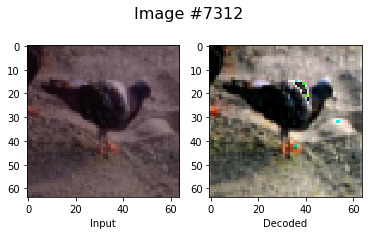

In [123]:
_ = sampleAE(hundred_objs_ds, aeNet)

In [51]:
# correlation sparse

correlateDataset(hundred_objs_ds, aeNet)

0.8108926094776754

# Encode Movie Frames

In [ ]:
from models import SimpleConvAE, SimpleConvAESmall, FeatureNet
from utils.fitUtils import encode_all_forrest_mult_autoencoders

autoencoders = {
    'SimpleConvAE':  SimpleConvAE().cuda(),
    'SimpleConvAESmall': SimpleConvAESmall().cuda()
}
        
encode_all_forrest_mult_autoencoders(autoencoders, 'test')

# Train Feature Models

In [ ]:
from utils.fitUtils import experiment_all_subjects

feature_models = ['Pixels', 'SimpleConvAE', 'SimpleConvAESmall', 'SparseAE']
experiment_all_subjects(50, save_name='test')

# Show Results

2


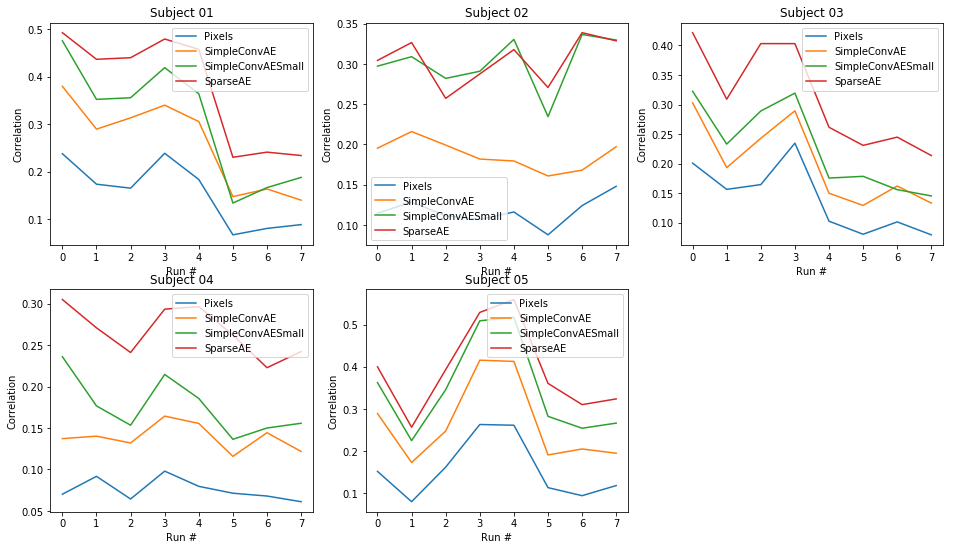

2


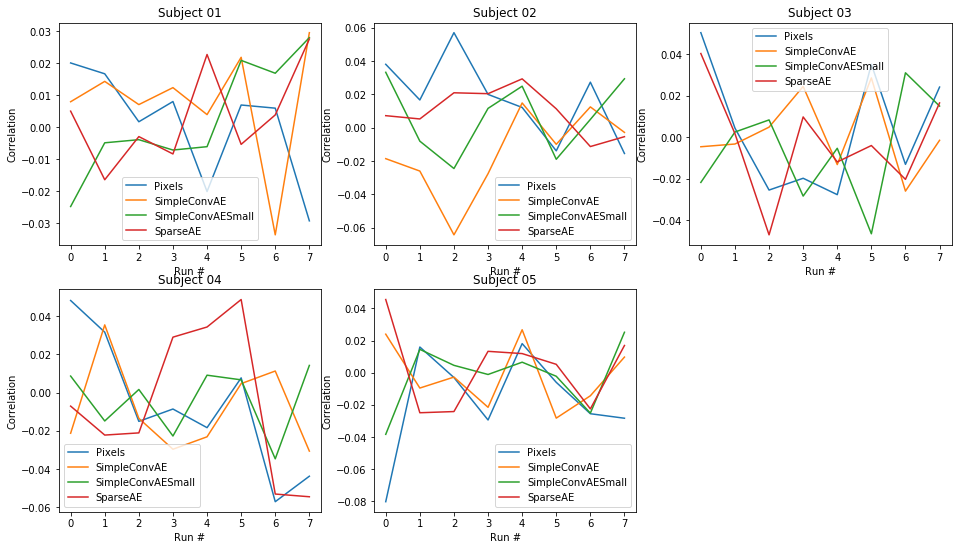

In [18]:
from utils.plotutils import plot_all_results

subjects = [i for i in range (1, 5 + 1)]
feature_models = ['Pixels', 'SimpleConvAE', 'SimpleConvAESmall', 'SparseAE']
plot_all_results(subjects, feature_models, (2,3), 0, results_save_name='march29')
plot_all_results(subjects, feature_models, (2,3), 1, results_save_name='march29')

# Experimental Stuff Below

## Try with Linear Regression

In [ ]:
def featureAcrossTimeCorr(x):
    return np.corrcoef(x[:, 0], x[:, 1])[0, 1]
    
X, y = dataset_to_npy(testdata)
y_pred = testmodel.predict(X)
preds_and_labels = np.stack([y_pred, y], axis=2)
preds_and_labels = np.swapaxes(preds_and_labels, 0, 1)

corrs = [featureAcrossTimeCorr(x) for x in preds_and_labels]

In [10]:
from torch.utils.data import BatchSampler, RandomSampler, ConcatDataset, DataLoader
from sklearn.linear_model import LinearRegression
from scipy import stats

def dataset_to_npy(dataset):
    num_samples = len(dataset)
    len_features = dataset.__getitem__(0)[0].shape[0]
    len_labels = dataset.__getitem__(0)[1].shape[0]
    X = np.empty((num_samples, len_features))
    y = np.empty((num_samples, len_labels))
    for i in range(num_samples):
        X[i] = dataset.__getitem__(0)[0]
        y[i] = dataset.__getitem__(0)[1]
    return X, y

def features_corr_LR(dataset, model):
    """ Returns average correlation of output of given linear model vs brain response """
    def featureAcrossTimeCorr(x):
        return np.corrcoef(x[:, 0], x[:, 1])[0, 1]

    X, y = dataset_to_npy(dataset)
    y_pred = model.predict(X)
    preds_and_labels = np.stack([y_pred, y], axis=2)
    preds_and_labels = np.swapaxes(preds_and_labels, 0, 1)

    corrs = [featureAcrossTimeCorr(x) for x in preds_and_labels]
    return sum(corrs)/len(corrs)

def linear_regression_cross_eval(datasets, outputPath, epochs, debug=False):
    eval_scores = np.empty((8, 8))
    for test_run_idx in range(8):
        # create indices for train and test split
        train_runs_indices = [j for j in range(8)]
        train_runs_indices.pop(test_run_idx)
        train_dataset_list = [datasets[j] for j in train_runs_indices]

        # create combined training set
        combined_train_dataset = ConcatDataset(train_dataset_list)
        train_sampler = RandomSampler(combined_train_dataset)
        train_loader = DataLoader(combined_train_dataset, sampler=train_sampler, batch_size=64, num_workers=0, pin_memory=True)
        
        X_train, y_train = dataset_to_npy(train_loader.dataset)

        # Fit model
        model = LinearRegression()
        model.fit(X_train, y_train)
    
        global testdata
        global testmodel
        testdata = datasets[0]
        testmodel = model
        print("good to go")
        # Each column stores the individual run correlations for a given test set
        for run_idx, run in enumerate(datasets):
            eval_scores[run_idx, test_run_idx] = features_corr_LR(datasets[run_idx], model)
        
        # Save data
        np.save(outputPath, eval_scores)
    return eval_scores

In [ ]:
testdata = None
testmodel = None

def experiment_all_subjects_LR(save_name=''):
    
    subjects = [i for i in range (1, 5 + 1)] # 20 total subjects
    for sub in subjects:
        print("Training LR on subject {}... ".format(sub), end='')

        all_run_datasets = loadPixelRunDataset(sub)
        save_path = os.path.join(Paths.results_path, 'sub-{:02d}'.format(sub), '{}-{}.npy'.format('LR', results_save_name))
        linear_regression_cross_eval(all_run_datasets, save_path, sub)

        print("done.")
experiment_all_subjects_LR(save_name=results_save_name)